# Multiclass Classification Problem with CIFAR-10 Dataset - Learning Rate Analysis

> **Part 01 of the Final Project - PPGEEC2318 Machine Learning**

> **Graduate Program in Electrical and Computer Engineering - Department of Computer Engineering and Automation**

> **Professor**: Ivanovitch M. Silva

> **Students**:
>> Leandro Roberto Silva Farias - 20251011748 \\
>> Nicholas Medeiros Lopes - 20251011739

# Dataset Description

In this notebook, we'll be analyzing a subset of the **CIFAR-10 dataset** to develop a convolutional neural network (CNN) with PyTorch, aiming to classify images into one of three object categories: **airplane**, **automobile**, or **ship**.

The **CIFAR-10** dataset is a well-known benchmark in computer vision, consisting of 60,000 color images (32×32 pixels) across 10 different classes. However, for the purposes of this project, we selected only the following 3 classes:

- **Airplane**  
- **Automobile**  
- **Ship**  

Each image is a small, low-resolution RGB photo, making this a good dataset for testing lightweight models and data augmentation strategies.

The **target variable** is the class label of the image, encoded as:

- **0 = Airplane**  
- **1 = Automobile**  
- **2 = Ship**  

This setup characterizes a **multiclass classification problem with 3 classes**, rather than the full 10-class setup from the original dataset. The selected subset is **balanced**, with roughly equal numbers of samples per class.

We'll preprocess the data, perform visualization, and train deep learning models to distinguish between these transport-related categories using visual cues.

You can access the full dataset at [CIFAR-10 - Kaggle Dataset](https://www.kaggle.com/datasets/ayush1220/cifar10).

# Initial Steps

## Libraries and Funtions

In [ ]:
# Import standard libraries for randomness, deep copying, and numerical operations
import random
import numpy as np
from copy import deepcopy

# Import libraries for image processing and data manipulation
from PIL import Image
import pandas as pd

# Import PyTorch core and utilities for deep learning
import torch
import torch.optim as optim  # Optimization algorithms
import torch.nn as nn  # Neural network modules
import torch.nn.functional as F  # Functional API for non-parametric operations

# Import PyTorch utilities for data loading and transformations
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision.transforms.v2 import Compose, ToImage, Normalize, ToPILImage, Resize, ToDtype

# Import dataset handling and learning rate schedulers
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

# Import visualization and web utilities
import matplotlib.pyplot as plt
import requests
import zipfile
import os
import errno
import kagglehub
import seaborn as sns

# Import model evaluation utilities
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Set matplotlib style for better visuals
plt.style.use('fivethirtyeight')

In [ ]:
def plot_confusion_matrix(architecture, data_loader, class_names):
    """
    Computes and plots the confusion matrix.

    Args:
        architecture (Architecture): The trained Architecture object.
        data_loader (DataLoader): The DataLoader for the validation data.
        class_names (list): A list of class names.
    """
    architecture.model.eval()  # Set model to evaluation mode
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(architecture.device)
            y_batch = y_batch.to(architecture.device)
            yhat = architecture.model(x_batch)

            if yhat.shape[1] > 1:
                _, predicted = torch.max(yhat, 1)
            else:
                predicted = (torch.sigmoid(yhat) > 0.5).long()

            all_labels.extend(y_batch.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


## Architecture Class

In [ ]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

        # for hook purposes
        self.handles = {}
        self.visualization = {}

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    # this function was updated in this class
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass

    def train(self, n_epochs, seed=42):
        self.set_seed(seed)

        for epoch in range(n_epochs):
            self.total_epochs += 1

            # Perform training step
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # Print the training loss after each epoch
            print(f"Epoch {epoch + 1}/{n_epochs} - Training Loss: {loss:.4f}")

            # Perform validation step (no gradients)
            with torch.no_grad():
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            # Print the validation loss after each epoch
            print(f"Epoch {epoch + 1}/{n_epochs} - Validation Loss: {val_loss:.4f}")

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def count_parameters(self):
      return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    @staticmethod
    def _visualize_tensors(axs, x, y=None, yhat=None, layer_name='', title=None):
        # The number of images is the number of subplots in a row
        n_images = len(axs)
        # Gets max and min values for scaling the grayscale
        minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
        # For each image
        for j, image in enumerate(x[:n_images]):
            ax = axs[j]
            # Sets title, labels, and removes ticks
            if title is not None:
                ax.set_title(f'{title} #{j}', fontsize=12)
            shp = np.atleast_2d(image).shape
            ax.set_ylabel(
                f'{layer_name}\n{shp[0]}x{shp[1]}',
                rotation=0, labelpad=40
            )
            xlabel1 = '' if y is None else f'\nLabel: {y[j]}'
            xlabel2 = '' if yhat is None else f'\nPredicted: {yhat[j]}'
            xlabel = f'{xlabel1}{xlabel2}'
            if len(xlabel):
                ax.set_xlabel(xlabel, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])

            # Plots weight as an image
            ax.imshow(
                np.atleast_2d(image.squeeze()),
                cmap='gray',
                vmin=minv,
                vmax=maxv
            )
        return

    def visualize_filters(self, layer_name, **kwargs):
        try:
            # Gets the layer object from the model
            layer = self.model
            for name in layer_name.split('.'):
                layer = getattr(layer, name)
            # We are only looking at filters for 2D convolutions
            if isinstance(layer, nn.Conv2d):
                # Takes the weight information
                weights = layer.weight.data.cpu().numpy()
                # weights -> (channels_out (filter), channels_in, H, W)
                n_filters, n_channels, _, _ = weights.shape

                # Builds a figure
                size = (2 * n_channels + 2, 2 * n_filters)
                fig, axes = plt.subplots(n_filters, n_channels,
                                        figsize=size)
                axes = np.atleast_2d(axes)
                axes = axes.reshape(n_filters, n_channels)
                # For each channel_out (filter)
                for i in range(n_filters):
                    Architecture._visualize_tensors(
                        axes[i, :],
                        weights[i],
                        layer_name=f'Filter #{i}',
                        title='Channel'
                    )

                for ax in axes.flat:
                    ax.label_outer()

                fig.tight_layout()
                return fig
        except AttributeError:
            return

    def attach_hooks(self, layers_to_hook, hook_fn=None):
        # Clear any previous values
        self.visualization = {}
        # Creates the dictionary to map layer objects to their names
        modules = list(self.model.named_modules())
        layer_names = {layer: name for name, layer in modules[1:]}

        if hook_fn is None:
            # Hook function to be attached to the forward pass
            def hook_fn(layer, inputs, outputs):
                # Gets the layer name
                name = layer_names[layer]
                # Detaches outputs
                values = outputs.detach().cpu().numpy()
                # Since the hook function may be called multiple times
                # for example, if we make predictions for multiple mini-batches
                # it concatenates the results
                if self.visualization[name] is None:
                    self.visualization[name] = values
                else:
                    self.visualization[name] = np.concatenate([self.visualization[name], values])

        for name, layer in modules:
            # If the layer is in our list
            if name in layers_to_hook:
                # Initializes the corresponding key in the dictionary
                self.visualization[name] = None
                # Register the forward hook and keep the handle in another dict
                self.handles[name] = layer.register_forward_hook(hook_fn)

    def remove_hooks(self):
        # Loops through all hooks and removes them
        for handle in self.handles.values():
            handle.remove()
        # Clear the dict, as all hooks have been removed
        self.handles = {}

    def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
        layers = filter(lambda l: l in self.visualization.keys(), layers)
        layers = list(layers)
        shapes = [self.visualization[layer].shape for layer in layers]
        n_rows = [shape[1] if len(shape) == 4 else 1
                  for shape in shapes]
        total_rows = np.sum(n_rows)

        fig, axes = plt.subplots(total_rows, n_images,
                                figsize=(1.5*n_images, 1.5*total_rows))
        axes = np.atleast_2d(axes).reshape(total_rows, n_images)

        # Loops through the layers, one layer per row of subplots
        row = 0
        for i, layer in enumerate(layers):
            start_row = row
            # Takes the produced feature maps for that layer
            output = self.visualization[layer]

            is_vector = len(output.shape) == 2

            for j in range(n_rows[i]):
                Architecture._visualize_tensors(
                    axes[row, :],
                    output if is_vector else output[:, j].squeeze(),
                    y,
                    yhat,
                    layer_name=layers[i] \
                              if is_vector \
                              else f'{layers[i]}\nfil#{row-start_row}',
                    title='Image' if (row == 0) else None
                )
                row += 1

        for ax in axes.flat:
            ax.label_outer()

        plt.tight_layout()
        return fig

    def correct(self, x, y, threshold=.5):
        self.model.eval()
        yhat = self.model(x.to(self.device))
        y = y.to(self.device)
        self.model.train()

        # We get the size of the batch and the number of classes
        # (only 1, if it is binary)
        n_samples, n_dims = yhat.shape
        if n_dims > 1:
            # In a multiclass classification, the biggest logit
            # always wins, so we don't bother getting probabilities

            # This is PyTorch's version of argmax,
            # but it returns a tuple: (max value, index of max value)
            _, predicted = torch.max(yhat, 1)
        else:
            n_dims += 1
            # In binary classification, we NEED to check if the
            # last layer is a sigmoid (and then it produces probs)
            if isinstance(self.model, nn.Sequential) and \
              isinstance(self.model[-1], nn.Sigmoid):
                predicted = (yhat > threshold).long()
            # or something else (logits), which we need to convert
            # using a sigmoid
            else:
                predicted = (F.sigmoid(yhat) > threshold).long()

        # How many samples got classified correctly for each class
        result = []
        for c in range(n_dims):
            n_class = (y == c).sum().item()
            n_correct = (predicted[y == c] == c).sum().item()
            result.append((n_correct, n_class))
        return torch.tensor(result)


    @staticmethod
    def loader_apply(loader, func, reduce='sum'):
        results = [func(x, y) for i, (x, y) in enumerate(loader)]
        results = torch.stack(results, axis=0)

        if reduce == 'sum':
            results = results.sum(axis=0)
        elif reduce == 'mean':
            results = results.float().mean(axis=0)

        return results

    @staticmethod
    def statistics_per_channel(images, labels):
        # NCHW
        n_samples, n_channels, n_height, n_weight = images.size()
        # Flatten HW into a single dimension
        flatten_per_channel = images.reshape(n_samples, n_channels, -1)

        # Computes statistics of each image per channel
        # Average pixel value per channel
        # (n_samples, n_channels)
        means = flatten_per_channel.mean(axis=2)
        # Standard deviation of pixel values per channel
        # (n_samples, n_channels)
        stds = flatten_per_channel.std(axis=2)

        # Adds up statistics of all images in a mini-batch
        # (1, n_channels)
        sum_means = means.sum(axis=0)
        sum_stds = stds.sum(axis=0)
        # Makes a tensor of shape (1, n_channels)
        # with the number of samples in the mini-batch
        n_samples = torch.tensor([n_samples]*n_channels).float()

        # Stack the three tensors on top of one another
        # (3, n_channels)
        return torch.stack([n_samples, sum_means, sum_stds], axis=0)

    @staticmethod
    def make_normalizer(loader):
        total_samples, total_means, total_stds = Architecture.loader_apply(loader, Architecture.statistics_per_channel)
        norm_mean = total_means / total_samples
        norm_std = total_stds / total_samples
        return Normalize(mean=norm_mean, std=norm_std)

    def lr_range_test(self, data_loader, end_lr, num_iter=100, step_mode='exp', alpha=0.05, ax=None):
        # Since the test updates both model and optimizer we need to store
        # their initial states to restore them in the end
        previous_states = {'model': deepcopy(self.model.state_dict()),
                          'optimizer': deepcopy(self.optimizer.state_dict())}
        # Retrieves the learning rate set in the optimizer
        start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']

        # Builds a custom function and corresponding scheduler
        lr_fn = make_lr_fn(start_lr, end_lr, num_iter)
        scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)

        # Variables for tracking results and iterations
        tracking = {'loss': [], 'lr': []}
        iteration = 0

        # If there are more iterations than mini-batches in the data loader,
        # it will have to loop over it more than once
        while (iteration < num_iter):
            # That's the typical mini-batch inner loop
            for x_batch, y_batch in data_loader:
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                # Step 1
                yhat = self.model(x_batch)
                # Step 2
                loss = self.loss_fn(yhat, y_batch)
                # Step 3
                loss.backward()

                # Here we keep track of the losses (smoothed)
                # and the learning rates
                tracking['lr'].append(scheduler.get_last_lr()[0])
                if iteration == 0:
                    tracking['loss'].append(loss.item())
                else:
                    prev_loss = tracking['loss'][-1]
                    smoothed_loss = alpha * loss.item() + (1-alpha) * prev_loss
                    tracking['loss'].append(smoothed_loss)

                iteration += 1
                # Number of iterations reached
                if iteration == num_iter:
                    break

                # Step 4
                self.optimizer.step()
                scheduler.step()
                self.optimizer.zero_grad()

        # Restores the original states
        self.optimizer.load_state_dict(previous_states['optimizer'])
        self.model.load_state_dict(previous_states['model'])

        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        else:
            fig = ax.get_figure()
        ax.plot(tracking['lr'], tracking['loss'])
        if step_mode == 'exp':
            ax.set_xscale('log')
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Loss')
        fig.tight_layout()
        return tracking, fig

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

In [ ]:
class CNN2(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN2, self).__init__()
        self.n_feature = n_feature
        self.p = p
        # Creates the convolution layers
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=n_feature,
                               kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature,
                               out_channels=n_feature,
                               kernel_size=3)
        # Creates the linear layers
        # Where do this 5 * 5 come from?! Check it below
        self.fc1 = nn.Linear(n_feature * 5 * 5, 50)
        self.fc2 = nn.Linear(50, 3)
        #self.fc2 = nn.Linear(50, 10)
        # Creates dropout layers
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # Featurizer
        # First convolutional block
        # 3@28x28 -> n_feature@26x26 -> n_feature@13x13
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Second convolutional block
        # n_feature * @13x13 -> n_feature@11x11 -> n_feature@5x5
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Input dimension (n_feature@5x5)
        # Output dimension (n_feature * 5 * 5)
        x = nn.Flatten()(x)
        return x

    def classifier(self, x):
        # Classifier
        # Hidden Layer
        # Input dimension (n_feature * 5 * 5)
        # Output dimension (50)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        # Output Layer
        # Input dimension (50)
        # Output dimension (3)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

# Dataset (Import and Preprocessing)

## Data Generation

In [ ]:
with zipfile.ZipFile("cifar10_subset.zip", 'r') as zip_ref:
        zip_ref.extractall('')

In [ ]:
path_train = 'cifar10_subset/train'
print("Path to dataset files for training:", path_train)

Path to dataset files for training: cifar10_subset/train


In [ ]:
path_test = 'cifar10_subset/test'
print("Path to dataset files for test:", path_test)

Path to dataset files for test: cifar10_subset/test


In [ ]:
def figure1(folder=path_train):
    airplane = Image.open(f'{folder}/airplane/0001.png')
    automobile = Image.open(f'{folder}/automobile/0001.png')
    ship = Image.open(f'{folder}/ship/0001.png')

    images = [airplane, automobile, ship]
    titles = ['Airplane', 'Automobile', 'Ship']

    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    for ax, image, title in zip(axs, images, titles):
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(title)

    return fig

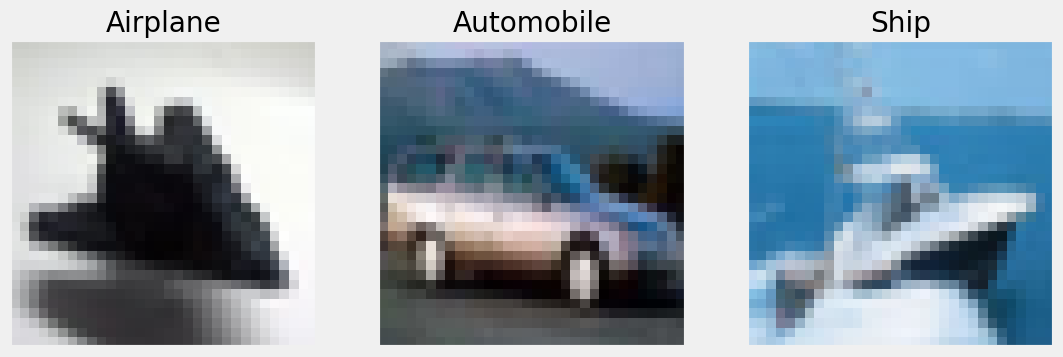

In [ ]:
fig = figure1()

## Data Preparation

### Image Folder

In [ ]:
# Compose a sequence of preprocessing transforms
# 1) Resize images to 28×28 pixels
# 2) Ensure output is a PIL/torchvision Image (dropping any alpha channel)
# 3) Convert pixel values to float32 and scale from [0–255] to [0.0–1.0]
temp_transform = Compose([
    Resize(28),                        # Resize each image to 28×28
    ToImage(),                         # Convert tensor back to PIL Image (enforces RGB)
    ToDtype(torch.float32, scale=True) # Cast to float32 and normalize pixel range
])

# Create an ImageFolder dataset from the 'rps' directory
# Images are grouped by subfolder name as class labels, and each image is transformed
temp_dataset = ImageFolder(
    root=path_train,
    transform=temp_transform          # Apply the preprocessing pipeline to every image
)

In [ ]:
# the second element of this tuple is the label
temp_dataset[0][0].shape, temp_dataset[0][1]

(torch.Size([3, 28, 28]), 0)

In [ ]:
temp_dataset[0][0]

Image([[[0.7961, 0.8000, 0.8078,  ..., 0.8157, 0.8118, 0.8000],
        [0.8118, 0.8118, 0.8196,  ..., 0.8314, 0.8235, 0.8118],
        [0.8275, 0.8314, 0.8392,  ..., 0.8510, 0.8431, 0.8314],
        ...,
        [0.8275, 0.7608, 0.6353,  ..., 0.9529, 0.9569, 0.9569],
        [0.8549, 0.8392, 0.7961,  ..., 0.9451, 0.9490, 0.9490],
        [0.8510, 0.8471, 0.8471,  ..., 0.9333, 0.9373, 0.9412]],

       [[0.8039, 0.8078, 0.8157,  ..., 0.8196, 0.8157, 0.8039],
        [0.8196, 0.8196, 0.8275,  ..., 0.8353, 0.8275, 0.8157],
        [0.8353, 0.8392, 0.8471,  ..., 0.8510, 0.8431, 0.8314],
        ...,
        [0.8275, 0.7569, 0.6353,  ..., 0.9451, 0.9529, 0.9529],
        [0.8510, 0.8353, 0.8000,  ..., 0.9412, 0.9451, 0.9451],
        [0.8471, 0.8431, 0.8431,  ..., 0.9294, 0.9333, 0.9333]],

       [[0.7843, 0.7882, 0.7961,  ..., 0.7922, 0.7843, 0.7804],
        [0.8000, 0.8039, 0.8118,  ..., 0.8118, 0.8039, 0.7922],
        [0.8157, 0.8235, 0.8353,  ..., 0.8353, 0.8275, 0.8157],
        ..

In [ ]:
# Get total number of samples in the dataset
dataset_size = len(temp_dataset)
print(f"Dataset size: {dataset_size} images")

# Get number of classes
num_classes = len(temp_dataset.classes)
print(f"Number of classes: {num_classes}")

Dataset size: 15000 images
Number of classes: 3


## Standardization

In [ ]:
temp_loader = DataLoader(temp_dataset, batch_size=16)

In [ ]:
# Each column represents a channel
# first row is the number of data points
# second row is the the sum of mean values
# third row is the sum of standard deviations
first_images, first_labels = next(iter(temp_loader))
Architecture.statistics_per_channel(first_images, first_labels)

tensor([[16.0000, 16.0000, 16.0000],
        [ 7.9410,  8.3654,  8.4420],
        [ 3.1684,  3.0491,  3.2941]])

In [ ]:
# We can leverage the loader_apply() method to get the sums for the whole dataset:
results = Architecture.loader_apply(temp_loader, Architecture.statistics_per_channel)
results

tensor([[15000.0000, 15000.0000, 15000.0000],
        [ 7438.2959,  7704.1758,  7956.8765],
        [ 3008.9990,  2956.7046,  3079.8013]])

In [ ]:
# we can compute the average mean value and the average standard deviation, per channel.
# Better yet, let’s make it a method that takes a data loader and
# returns an instance of the Normalize() transform
normalizer = Architecture.make_normalizer(temp_loader)
normalizer

Normalize(mean=[tensor(0.4959), tensor(0.5136), tensor(0.5305)], std=[tensor(0.2006), tensor(0.1971), tensor(0.2053)], inplace=False)

## The Real Datasets

In [ ]:
# Define a pipeline of image transformations:
# 1) Resize each image to 28×28 pixels
# 2) Ensure the output is a PIL/torchvision image (dropping any alpha channel)
# 3) Cast pixels to float32 and scale from [0–255] to [0.0–1.0]
# 4) Apply the user-defined normalization (e.g., mean/std normalization)
composer = Compose([
    Resize(28),                         # Resize to 28×28
    ToImage(),                          # Convert to PIL Image in RGB
    ToDtype(torch.float32, scale=True), # Cast to float32 and normalize to [0,1]
    normalizer                          # Apply custom normalization transform
])

# Instantiate training and validation datasets from folders:
# - 'rps' contains subfolders per class for training
# - 'rps-test-set' likewise for validation
train_data = ImageFolder(root=path_train, transform=composer)
val_data   = ImageFolder(root=path_test, transform=composer)

# Wrap datasets in DataLoaders for batching and shuffling:
# - batch_size=16 yields mini-batches of 16 images
# - shuffle=True randomizes training order each epoch
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_data,   batch_size=16)  # no shuffle for validation

In [ ]:
def figure2(first_images, first_labels):
    fig, axs = plt.subplots(1, 6, figsize=(12, 4))
    titles = ['Airplane', 'Automobile', 'Ship']
    for i in range(6):
        image, label = ToPILImage()(first_images[i]), first_labels[i]
        axs[i].imshow(image)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(titles[label], fontsize=12)
    fig.tight_layout()
    return fig

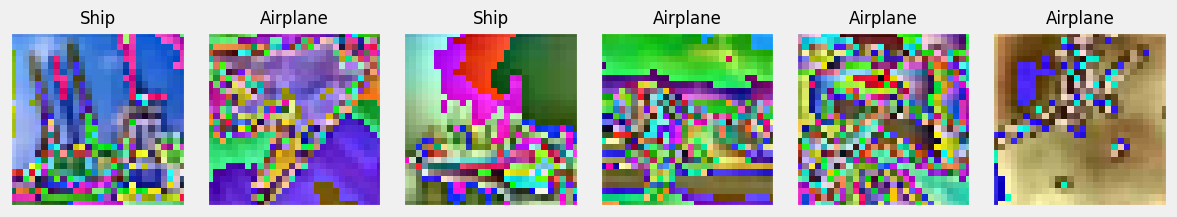

In [ ]:
torch.manual_seed(88)
first_images, first_labels = next(iter(train_loader))

fig = figure2(first_images, first_labels)

# Learning Rate Analysis

### Finding LR

In [ ]:
def make_lr_fn(start_lr, end_lr, num_iter, step_mode='exp'):
    if step_mode == 'linear':
        factor = (end_lr / start_lr - 1) / num_iter
        def lr_fn(iteration):
            return 1 + iteration * factor
    else:
        factor = (np.log(end_lr) - np.log(start_lr)) / num_iter
        def lr_fn(iteration):
            return np.exp(factor)**iteration
    return lr_fn

In [ ]:
start_lr = 0.01
end_lr = 0.1
num_iter = 10
lr_fn = make_lr_fn(start_lr, end_lr, num_iter, step_mode='exp')

In [ ]:
lr_fn(np.arange(num_iter + 1))

array([ 1.        ,  1.25892541,  1.58489319,  1.99526231,  2.51188643,
        3.16227766,  3.98107171,  5.01187234,  6.30957344,  7.94328235,
       10.        ])

In [ ]:
start_lr * lr_fn(np.arange(num_iter + 1))

array([0.01      , 0.01258925, 0.01584893, 0.01995262, 0.02511886,
       0.03162278, 0.03981072, 0.05011872, 0.06309573, 0.07943282,
       0.1       ])

In [ ]:
dummy_model = CNN2(n_feature=15, p=0.3)
dummy_optimizer = optim.Adam(dummy_model.parameters(), lr=start_lr)
dummy_scheduler = LambdaLR(dummy_optimizer, lr_lambda=lr_fn)

In [ ]:
dummy_optimizer.step()
dummy_scheduler.step()

In [ ]:
dummy_scheduler.get_last_lr()[0]

np.float64(0.012589254117941673)

In [ ]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)
except ModuleNotFoundError:
    pass

from config import *
config_chapter6()
# This is needed to render the plots in this chapter
from plots.chapter6 import *

Finished!


In [ ]:
def lr_range_test(self, data_loader, end_lr, num_iter=100, step_mode='exp', alpha=0.05, ax=None):
    # Since the test updates both model and optimizer we need to store
    # their initial states to restore them in the end
    previous_states = {'model': deepcopy(self.model.state_dict()),
                       'optimizer': deepcopy(self.optimizer.state_dict())}
    # Retrieves the learning rate set in the optimizer
    start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']

    # Builds a custom function and corresponding scheduler
    lr_fn = make_lr_fn(start_lr, end_lr, num_iter)
    scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)

    # Variables for tracking results and iterations
    tracking = {'loss': [], 'lr': []}
    iteration = 0

    # If there are more iterations than mini-batches in the data loader,
    # it will have to loop over it more than once
    while (iteration < num_iter):
        # That's the typical mini-batch inner loop
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            # Step 1
            yhat = self.model(x_batch)
            # Step 2
            loss = self.loss_fn(yhat, y_batch)
            # Step 3
            loss.backward()

            # Here we keep track of the losses (smoothed)
            # and the learning rates
            tracking['lr'].append(scheduler.get_last_lr()[0])
            if iteration == 0:
                tracking['loss'].append(loss.item())
            else:
                prev_loss = tracking['loss'][-1]
                smoothed_loss = alpha * loss.item() + (1-alpha) * prev_loss
                tracking['loss'].append(smoothed_loss)

            iteration += 1
            # Number of iterations reached
            if iteration == num_iter:
                break

            # Step 4
            self.optimizer.step()
            scheduler.step()
            self.optimizer.zero_grad()

    # Restores the original states
    self.optimizer.load_state_dict(previous_states['optimizer'])
    self.model.load_state_dict(previous_states['model'])

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    else:
        fig = ax.get_figure()
    ax.plot(tracking['lr'], tracking['loss'])
    if step_mode == 'exp':
        ax.set_xscale('log')
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Loss')
    fig.tight_layout()
    return tracking, fig

setattr(StepByStep, 'lr_range_test', lr_range_test)

In [ ]:
torch.manual_seed(13)
new_model = CNN2(n_feature=15, p=0.3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
new_optimizer = optim.Adam(new_model.parameters(), lr=3e-4)

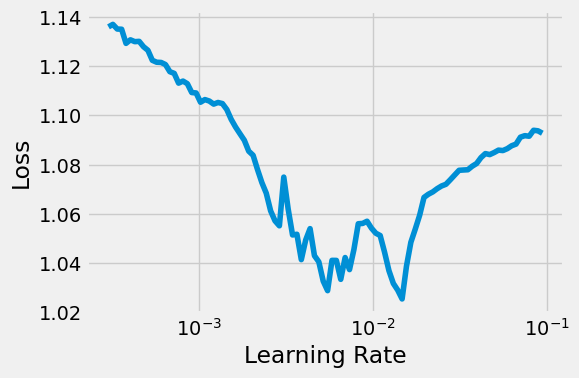

In [ ]:
sbs_new = StepByStep(new_model, multi_loss_fn, new_optimizer)
tracking, fig = sbs_new.lr_range_test(train_loader, end_lr=1e-1, num_iter=100)

In [ ]:
def set_optimizer(self, optimizer):
    self.optimizer = optimizer

setattr(StepByStep, 'set_optimizer', set_optimizer)

In [ ]:
new_optimizer = optim.Adam(new_model.parameters(), lr=0.005)
sbs_new.set_optimizer(new_optimizer)
sbs_new.set_loaders(train_loader, val_loader)
sbs_new.train(10)

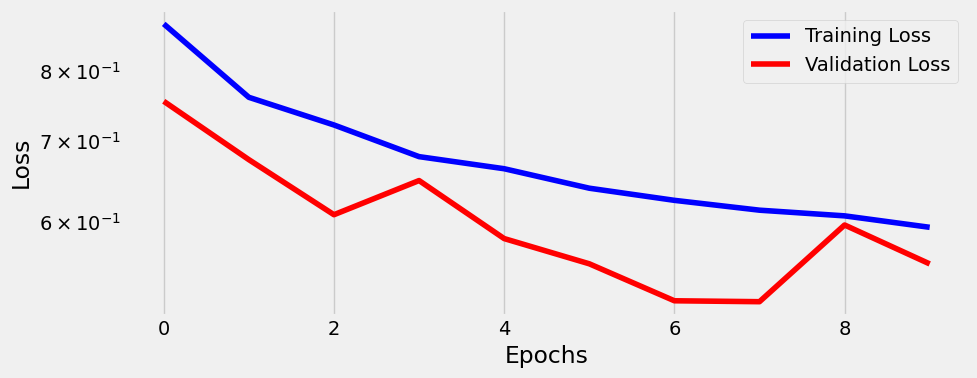

In [ ]:
# This plot wasn't included in the book
fig = sbs_new.plot_losses()

### LRFinder

In [ ]:
!pip install --quiet torch-lr-finder
from torch_lr_finder import LRFinder

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 132.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.2 MB/s eta 0:00:00


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.21E-03


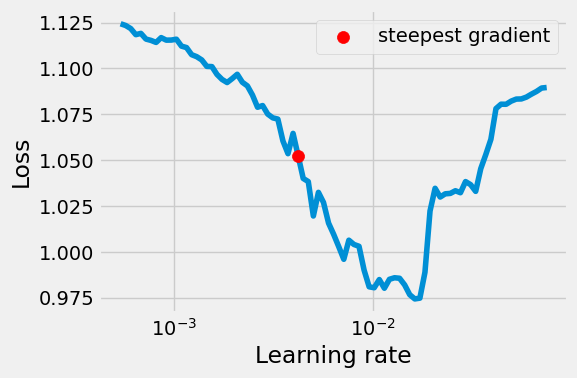

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

torch.manual_seed(11)
new_model = CNN2(n_feature=15, p=0.3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
new_optimizer = optim.Adam(new_model.parameters(), lr=3e-4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

lr_finder = LRFinder(new_model, new_optimizer, multi_loss_fn, device=device)
lr_finder.range_test(train_loader, end_lr=1e-1, num_iter=100)
lr_finder.plot(ax=ax, log_lr=True)

fig.tight_layout()
lr_finder.reset()

# Model with New Learning Rate

In [ ]:
# New learning rate after lr_finder analysis
new_lr = 4.21e-3

In [ ]:
torch.manual_seed(13)

# Model/Architecture
model_cnn4 = CNN2(n_feature=15, p=0.3)

# Loss function
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')

# Optimizer
optimizer_cnn4 = optim.Adam(model_cnn4.parameters(), lr=new_lr)

### Model Training

In [ ]:
arch_cnn4 = Architecture(model_cnn4,
                        multi_loss_fn,
                        optimizer_cnn4)
arch_cnn4.set_loaders(train_loader, val_loader)
arch_cnn4.train(30)

Epoch 1/30 - Training Loss: 0.8378
Epoch 1/30 - Validation Loss: 0.6643
Epoch 2/30 - Training Loss: 0.7127
Epoch 2/30 - Validation Loss: 0.5938
Epoch 3/30 - Training Loss: 0.6669
Epoch 3/30 - Validation Loss: 0.5265
Epoch 4/30 - Training Loss: 0.6383
Epoch 4/30 - Validation Loss: 0.5439
Epoch 5/30 - Training Loss: 0.6279
Epoch 5/30 - Validation Loss: 0.5649
Epoch 6/30 - Training Loss: 0.6055
Epoch 6/30 - Validation Loss: 0.5220
Epoch 7/30 - Training Loss: 0.5820
Epoch 7/30 - Validation Loss: 0.4870
Epoch 8/30 - Training Loss: 0.5654
Epoch 8/30 - Validation Loss: 0.4680
Epoch 9/30 - Training Loss: 0.5606
Epoch 9/30 - Validation Loss: 0.5031
Epoch 10/30 - Training Loss: 0.5411
Epoch 10/30 - Validation Loss: 0.4874
Epoch 11/30 - Training Loss: 0.5368
Epoch 11/30 - Validation Loss: 0.4619
Epoch 12/30 - Training Loss: 0.5317
Epoch 12/30 - Validation Loss: 0.4945
Epoch 13/30 - Training Loss: 0.5228
Epoch 13/30 - Validation Loss: 0.4726
Epoch 14/30 - Training Loss: 0.5196
Epoch 14/30 - Valida

In [ ]:
arch_cnn4.count_parameters()

21413

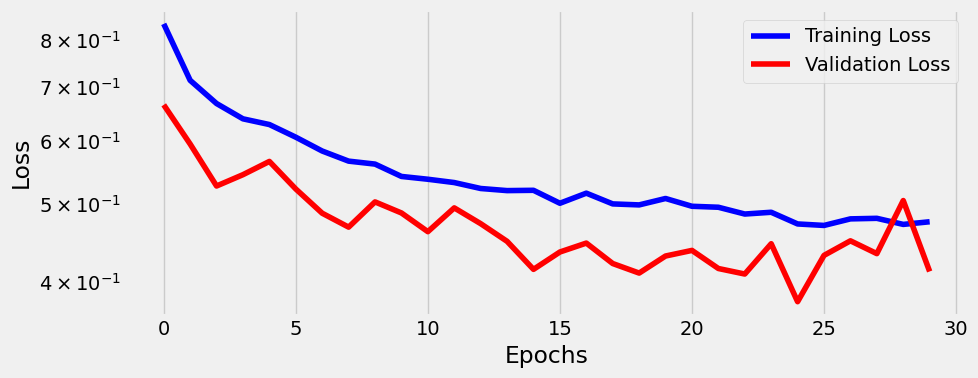

In [ ]:
fig = arch_cnn4.plot_losses()

### Model Evaluation

#### Accuracy

In [ ]:
Architecture.loader_apply(val_loader,
                          arch_cnn4.correct)

tensor([[ 789, 1000],
        [ 873, 1000],
        [ 862, 1000]])

In [ ]:
Architecture.loader_apply(val_loader,
                          arch_cnn4.correct).sum(axis=0)

tensor([2524, 3000])

In [ ]:
(lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(val_loader,
                                                                arch_cnn4.correct).sum(axis=0))

0.8413333333333334

#### Confusion Matrix

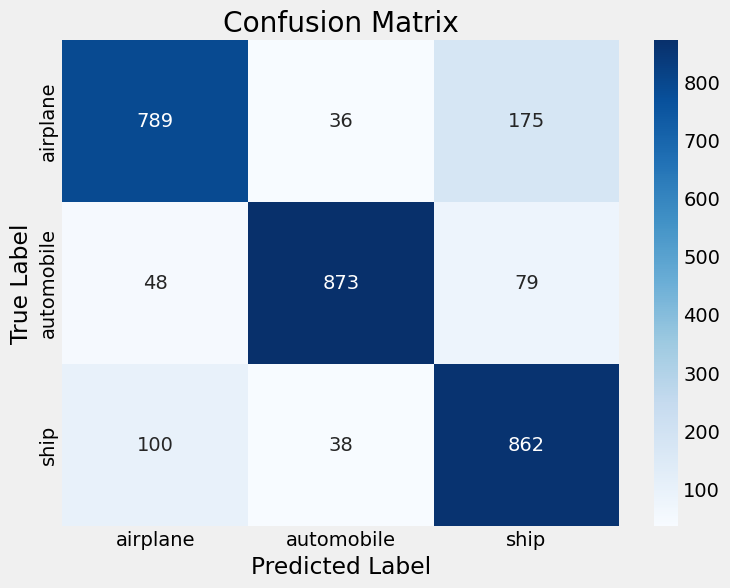

In [ ]:
class_names = train_data.classes # Get class names from the training dataset
plot_confusion_matrix(arch_cnn4, val_loader, class_names)

### Saving model

In [ ]:
# Salvar o modelo treinado
arch_cnn4.save_checkpoint('lr_analysis_model.pth')